In [1]:
import tensorflow as tf
import numpy as np
from tensorflow_vgg.utils import load_image, print_prob
from PIL import Image
import random

def rand_variable(shape, stddev=0.1):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial)

def to_pil(img):
    return Image.fromarray(np.clip(img * 255, 0, 255).astype(np.uint8))

In [2]:
from tensorflow_vgg.vgg19style import Vgg19

In [15]:
image_size = 256
image = rand_variable([1, image_size, image_size, 3])
# vgg = Vgg16(avg_pooling=True)
vgg = Vgg19('../data/vgg19.npy', avg_pooling=True)
with tf.name_scope('content_vgg'):
    vgg.build(image)

npy file loaded
build model started
build model finished: 0s


In [16]:
session = tf.Session()

In [40]:
# style transfer:
# starrynight.jpg
# lampbear.jpg
# mickey.jpg
# monalisa.jpg
# nate.jpg
# arthur.png

style_image = load_image('../data/subway-map-closeup.png', size=image_size)[:,:,:3].reshape((1,image_size,image_size,3))


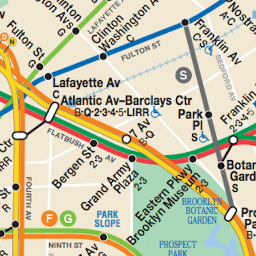

In [41]:
to_pil(style_image[0])

In [60]:
style_layers = [vgg.bgr, vgg.conv1_1, vgg.conv1_2, vgg.conv2_1, vgg.conv2_2, vgg.conv3_1, vgg.conv3_2, vgg.conv3_3, vgg.conv4_1, vgg.conv4_2, vgg.conv4_3, vgg.pool5]
style_layer_weights = [1 for layer in style_layers]

In [61]:
# get style layer activations:
session.run(image.assign(style_image))

def style_gram(layer):
    _, height, width, channels = [d.value for d in layer.get_shape()]
    features = tf.reshape(layer, [-1, channels])
    gram = tf.matmul(tf.transpose(features), features) / (width * height * channels)
    return gram

style_grams = session.run([style_gram(layer) for layer in style_layers])

In [62]:
STYLE_WEIGHT = 200
DENOISING_WEIGHT = 400

style_loss = tf.add_n([2 * tf.nn.l2_loss(target_gram - style_gram(layer)) / target_gram.size * w for layer, target_gram, w in zip(style_layers, style_grams, style_layer_weights)])

# total variational denoising
tv_x = tf.nn.l2_loss(image[:,1:,:,:] - image[:,:image_size-1,:,:])
tv_y = tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:image_size-1,:])
tv_loss = 2 * (tv_x + tv_y)

loss = STYLE_WEIGHT * style_loss + DENOISING_WEIGHT * tv_loss


In [63]:
learning_rate = tf.placeholder(tf.float32, shape=[])
stylize_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


Step: 0; loss: 398228832.0
Step: 10; loss: 68881752.0
Step: 20; loss: 35295516.0
Step: 30; loss: 14396313.0
Step: 40; loss: 10971508.0
Step: 50; loss: 8417064.0
Step: 60; loss: 6733988.0
Step: 70; loss: 5610283.0
Step: 80; loss: 4943714.0
Step: 90; loss: 4480815.5
Step: 100; loss: 4399579.5
Step: 110; loss: 4358357.5
Step: 120; loss: 4317755.0
Step: 130; loss: 4278237.0
Step: 140; loss: 4239518.0


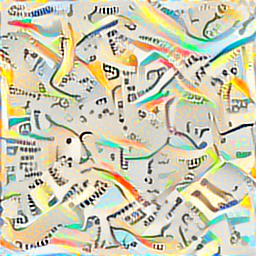

In [64]:

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

img_ = np.random.normal(size=[image_size,image_size,3], scale=np.std(style_image) * 0.2, loc=np.mean(style_image))

session.run(image.assign(np.array([img_])))
# dx = random.randint(-5, 5)
# dy = random.randint(-5, 5)
# img_rolled = np.roll(np.roll(img_, dy, axis=1), dx, axis=2)
# session.run(image.assign(img_rolled))

# _, loss_, img_ = session.run([train, loss, image])

# img_ = np.roll(np.roll(img_, -dx, axis=2), -dy, axis=1)

for step in xrange(150):
    # dx = 0 # int(np.random.normal(scale=5) ** 2)
    # dy = 0 # int(np.random.normal(scale=5) ** 2)
    # img_rolled = np.roll(np.roll(img_, dy, axis=0), dx, axis=1)
    
    # print img_rolled.shape
    # session.run(image.assign(np.array([img_rolled])))
    
    lr = 0.1
    if step > 90: lr = 0.01
    
    _, loss_ = session.run([stylize_op, loss], feed_dict={learning_rate: lr})
    # img_ = session.run(image[0])
    # print img_.shape
    # img_ = np.roll(np.roll(img_, -dx, axis=1), -dy, axis=0)
    if step % 10 == 0:
        print 'Step: {}; loss: {}'.format(step, loss_)

img_ = session.run(image[0])
to_pil(img_)